# Final Project 

## Task

The virtual telephony service CallMeMaybe is developing a new function that will give supervisors information on the least effective operators. An operator is considered ineffective if they have a large number of missed incoming calls (internal and external) and a long waiting time for incoming calls. Moreover, if an operator is supposed to make outgoing calls, a small number of them is also a sign of ineffectiveness.

- Carry out exploratory data analysis
- Identify ineffective operators
- Test statistical hypotheses

## Table of contents

1. [Downloading the data](#download)
    1. [Analysing The Clients Dataset](#analyse1)
    2. [Conclusion](#conclusion1)
    3. [Analysing The Telecom Dataset](#analyse2)
    4. [Detecting The Outliers](#outliers1)
    4. [Conclusion](#conclusion2)
2. [Step 2. Make reports on relevant metrics](#metrics)    
    1. [Trying To Detect A Pattern Of Users Who Signed Up With The Retention Cohort](#cohort) 
    2. [Analysing Users](#analysingusers)
    3. [Silhouette Analysis](#silhouette)
    4. [Plot Distributions Of Features For The Clusters](#clusters)
    5. [Cluster Descriptions](#clusterdescription)
    6. [Conclusion](#conclusion3)
3. [Step 3. Creating a hypothesis](#hypothesis)
    1. [Conclusion](#conclusion4)
4. [Step 5. Conclusion](#conclusion5) 
    
    

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.patches as mpatches

import seaborn as sns
import seaborn as sb
from plotly.subplots import make_subplots

import datetime as dt
from datetime import datetime

import math
import math as mth
from scipy import stats
from scipy import stats as st
import scipy.stats as st


from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from plotly import graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.renderers;

## Step 1. Download the data and prepare it for analysis <a name="download"></a>


### Analysing The Clients Dataset <a name="analyse1"></a>

In [5]:
telecom_clients = pd.read_csv('/Users/annaperkas/Downloads/telecom_clients_us (2).csv')
telecom_clients.head(5);

In [6]:
telecom_clients.tail(5);

In [7]:
telecom_clients.sample();

In [8]:
telecom_clients.shape

(732, 3)

The Telecom Clients dataset has 3 columns and 732 rows.

In [9]:
telecom_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


The date_start is not in the right format, so it should be changed to datetime.

In [10]:
telecom_clients['date_start'] = pd.to_datetime(telecom_clients['date_start'], format ="%Y-%m-%d %H:%M")

In [11]:
telecom_clients.describe()

,user_id
count,732.000000
mean,167431.927596
std,633.810383
min,166373.000000
25%,166900.750000
50%,167432.000000
75%,167973.000000
max,168606.000000


There are 732 users, and the numbering does not start with zero but rather, from sixteen thousand.

In [12]:
telecom_clients['date_start'].nsmallest(5)

107   2019-08-01
159   2019-08-01
301   2019-08-01
350   2019-08-01
374   2019-08-01
Name: date_start, dtype: datetime64[ns]

In [13]:
telecom_clients['date_start'].nlargest(5)

10    2019-10-31
64    2019-10-31
120   2019-10-31
121   2019-10-31
128   2019-10-31
Name: date_start, dtype: datetime64[ns]

The dates range from the 1st of August 2019 to the 31st of October. While the dates do not display hours, it is clear that we are talking about multiple users in the same day. The question here is if there is anything to explore or the data here does not have any depth. 

In [14]:
telecom_clients.tariff_plan.unique()

array(['A', 'C', 'B'], dtype=object)

There are 3 tariff plans, A, B, and C. We do not know what is the difference between them in terms of services offered.

In [15]:
telecom_clients.date_start.value_counts().sum()

732

In [16]:
telecom_clients.user_id.nunique()

732

In [17]:
telecom_clients.date_start.value_counts().sum()

732

In [18]:
telecom_clients.date_start.nunique()

73

In [19]:
telecom_clients.duplicated().sum()

0

### Conclusion <a name="conclusion4"></a>

The dataset does not have any complicated issues or pitfalls. There are no unknown values or duplicates.

What is worth noting is that the period is not significant to make accurate conclusions. For example, users' behavior or operator's behavior may be affected by some external circumstances, and three months period may not be enough to get an entire picture. 

### Analysing The Telecom Dataset <a name="analyse2"></a>

In [20]:
telecom_dataset = pd.read_csv('/Users/annaperkas/Downloads/telecom_dataset_us (1).csv')
telecom_dataset.head(5);

In [21]:
telecom_dataset.tail(5);

In [22]:
telecom_dataset.sample();

In [23]:
telecom_dataset.shape

(53902, 9)

The dataset has 9 columns and 53902 rows.Significantly longer than the previous one.

In [24]:
telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


Here again the date column needs to be changed to datetime. The rest of the columns are fine.

In [25]:
telecom_dataset['date'] = pd.to_datetime(telecom_dataset['date'], format ="%Y-%m-%d %H:%M")

In [26]:
telecom_dataset.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,53902.000000,45730.000000,53902.000000,53902.000000,53902.000000
mean,167295.344477,916535.993002,16.451245,866.684427,1157.133297
std,598.883775,21254.123136,62.917170,3731.791202,4403.468763
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166782.000000,900788.000000,1.000000,0.000000,47.000000
50%,167162.000000,913938.000000,4.000000,38.000000,210.000000
75%,167819.000000,937708.000000,12.000000,572.000000,902.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000


We know that call_duration and total_call_duration columns are in second, so the bizarre values make sense in this regard, but the range is quite significant, which makes it plausible to assume that there are outliers. The same goes for calls_count. It is not likely that one operator made 4817 calls while the rest range between 1 and 12.  Also, it is approximately 1600 calls a day. 

In [27]:
telecom_dataset['date'].nsmallest(5)

591    2019-08-02 00:00:00+03:00
1763   2019-08-02 00:00:00+03:00
1764   2019-08-02 00:00:00+03:00
1765   2019-08-02 00:00:00+03:00
1766   2019-08-02 00:00:00+03:00
Name: date, dtype: datetime64[ns, pytz.FixedOffset(180)]

In [28]:
telecom_dataset['date'].nlargest(5)

564   2019-11-28 00:00:00+03:00
565   2019-11-28 00:00:00+03:00
566   2019-11-28 00:00:00+03:00
567   2019-11-28 00:00:00+03:00
568   2019-11-28 00:00:00+03:00
Name: date, dtype: datetime64[ns, pytz.FixedOffset(180)]

The dates for receiving the stats are different from the dates where clients signed up, meaning that whatever system was used, the information was not synchronized immediately but rather aggregated overtime, even possibly with manual adjustments. 

What is essential to know is that it is still consistent with the sequence of events.

In [29]:
new_dates, new_times = zip(*[(d.date(), d.time()) for d in telecom_dataset['date']])
telecom_dataset = telecom_dataset.assign(date_stats=new_dates, new_time=new_times)

In [30]:
#telecom_dataset.head() #test

In [31]:
telecom_dataset.drop(['date', 'new_time'],axis=1,inplace=True)

The hours and dates were separated for a more uniform look.

In [32]:
telecom_dataset.operator_id.nunique()

1092

There are 1082 operators in the dataset.

In [33]:
telecom_dataset.user_id.value_counts().sum()

53902

### Detecting The Outliers <a name="outliers1"></a>

[Text(0, 0.5, 'Outliers'), Text(0.5, 0, 'Calls Count')]

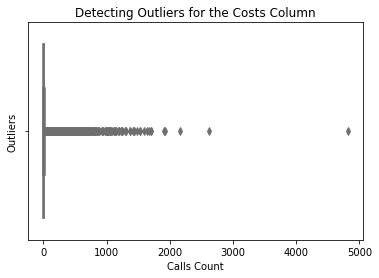

In [34]:
plt.title('Detecting Outliers for the Costs Column')
sns.boxplot(x= telecom_dataset['calls_count'],color= 'SkyBlue').set(xlabel='Calls Count', ylabel='Outliers')

In [35]:
outliers_calls_count = telecom_dataset['calls_count'].between(telecom_dataset['calls_count'].quantile(.05), telecom_dataset['calls_count'].quantile(.95))
outliers_calls_count.sum()

51229

In [36]:
percentage_of_outliers_1 = 51229 * 100 / 53902
percentage_of_outliers_1

95.04100033393937

In [37]:
telecom_dataset = telecom_dataset.query("calls_count < 2500")

Ok, this quite a significant number of outliers.But again, like we saw in the preliminary analysis, there were obviously some numbers that did not make sense.

[Text(0, 0.5, 'Outliers'), Text(0.5, 0, 'Call Duration')]

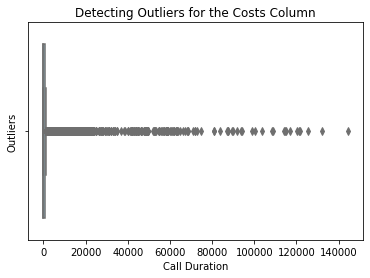

In [38]:
plt.title('Detecting Outliers for the Costs Column')
sns.boxplot(x= telecom_dataset['call_duration'],color= 'SkyBlue').set(xlabel='Call Duration', ylabel='Outliers')

In [39]:
outliers_calls_duration = telecom_dataset['call_duration'].between(telecom_dataset['call_duration'].quantile(.05), telecom_dataset['call_duration'].quantile(.95))
outliers_calls_duration.sum()


51205

In [40]:
percentage_of_outliers_1 = 51206 * 100 / 53902
percentage_of_outliers_1

94.99833030314274

In [41]:
telecom_dataset = telecom_dataset.query(" call_duration < 100000")

[Text(0, 0.5, 'Outliers'), Text(0.5, 0, 'Call Duration')]

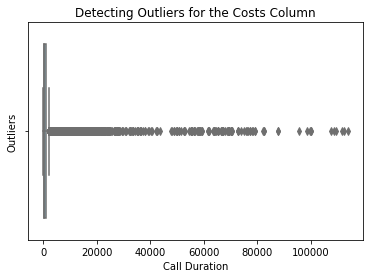

In [42]:
plt.title('Detecting Outliers for the Costs Column')
sns.boxplot(x= telecom_dataset['total_call_duration'],color= 'SkyBlue').set(xlabel='Call Duration', ylabel='Outliers')

In [43]:
outliers_calls_duration = telecom_dataset['total_call_duration'].between(telecom_dataset['total_call_duration'].quantile(.05), telecom_dataset['total_call_duration'].quantile(.95))
outliers_calls_duration.sum()

49345

In [44]:
percentage_of_outliers_1 = 49360 * 100 / 53902
percentage_of_outliers_1

91.57359652703053

In [45]:
telecom_dataset = telecom_dataset.query("total_call_duration < 100000")

More significant number of outliers in the columns above.Given the fact that all three columns are essential for the analysis and determining the effeciency of operators, we cannot leave the data skewed.

In [46]:
telecom_dataset.isna().mean().round(4) * 100

user_id                 0.00
direction               0.00
internal                0.22
operator_id            15.17
is_missed_call          0.00
calls_count             0.00
call_duration           0.00
total_call_duration     0.00
date_stats              0.00
dtype: float64

In [47]:
telecom_dataset.isnull().mean().round(4) * 100

user_id                 0.00
direction               0.00
internal                0.22
operator_id            15.17
is_missed_call          0.00
calls_count             0.00
call_duration           0.00
total_call_duration     0.00
date_stats              0.00
dtype: float64

There is a significant number of missing values in the operator_id column. Operator Ids are randomly generated, and while the column is numeric, it is not numeric in the sense that we can average it or replace the numbers with something else. Let's see what happens with duplicates to determine how to approach the issue.

In [48]:
telecom_dataset.duplicated().sum()

4899

There is a considerable number of duplicates. Relative to the dataset's size does not look that bad, but such a number can potentially skew the analysis. Let's see duplicates distribution. 

In [49]:
telecom_dataset[telecom_dataset.duplicated()].head() ;

In [50]:
for i in telecom_dataset[telecom_dataset.duplicated()].columns:
    print(i,":",telecom_dataset[telecom_dataset.duplicated()][i].nunique())

user_id : 269
direction : 2
internal : 2
operator_id : 776
is_missed_call : 2
calls_count : 177
call_duration : 1546
total_call_duration : 1819
date_stats : 115


The most significant number of duplicates are in the "total_call_duration" column and "call_duration." Both are important for the analysis. Let's see if they correspond to the missing values in the operator_id column that we have discovered.

In [51]:
telecom_dataset['date_stats'].describe()

count          53878
unique           119
top       2019-11-25
freq            1220
Name: date_stats, dtype: object

The most significant number of duplicates in the date column appears on the 25th of November.
It doesn't look like anything significant happened. I also searched for the news to make sure. Maybe someone was just busy preparing for Thanksgiving. We have already determined that the data (at least partially) was updated manually, so there is a potential for human error.

for refference:

https://www.wincalendar.com/Calendar/Date/November-25-2019

In [52]:
telecom_duplicated = telecom_dataset[telecom_dataset.duplicated(['operator_id','total_call_duration'])]
telecom_duplicated.duplicated().sum()

940

There are 940 duplicates between operator_id column and total_call_duration column.

In [53]:
total_call_duration_duplicated = (telecom_duplicated[(telecom_duplicated['total_call_duration']) & - (telecom_dataset['operator_id'].isnull())])
total_call_duration_duplicated.duplicated().sum()

129

One hundred twenty-nine duplicates are between missing values in the operator_id column and total_call_duration column.

In [54]:
telecom_duplicated_1 = telecom_dataset[telecom_dataset.duplicated(['operator_id','call_duration'])]
telecom_duplicated_1.duplicated().sum()

2117

There are 2117 duplicates alltogether between the call_durationa and operator_id column.

In [55]:
call_duration_duplicated = (telecom_duplicated[(telecom_duplicated['call_duration']) & - (telecom_dataset['operator_id'].isnull())])
call_duration_duplicated.duplicated().sum()

61

Out of the number above, there are 61 duplicates among the missing values.

In [56]:
telecom_dataset.drop_duplicates(inplace=True,keep=False)
telecom_dataset.duplicated().any()

False

In [57]:
telecom_dataset.dropna(how='all', inplace=True)

### Conclusion <a name="conclusion2"></a>

This dataset is severy problematic due to missing values and duplicates. All the columns are different, and we cannot replace one with another to compensate for the absence of data. It is a relief that some of the duplicates are also among the missing values in the operator_id column. However, a substantial part of them is outside of the 15 percent of the missing values. 

As we have seen, we cannot replace them with average because it would "create" new users and randomly distribute them, which would be bad for comparing the tariffs. Duplicates also should be dropped as we have determined that they are real duplicates and not just the same values.


## Step 2. Make reports on relevant metrics <a name="metrics"></a>

merging the datasets on user_id.

In [58]:
telecom_data = pd.merge(left= telecom_clients,right= telecom_dataset,how='outer',on=['user_id']).fillna(0)
telecom_data.head();

In [59]:
telecom_data = telecom_data[telecom_data['operator_id'] != 0]

In [60]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37340 entries, 1 to 44503
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              37340 non-null  int64         
 1   tariff_plan          37340 non-null  object        
 2   date_start           37340 non-null  datetime64[ns]
 3   direction            37340 non-null  object        
 4   internal             37340 non-null  object        
 5   operator_id          37340 non-null  float64       
 6   is_missed_call       37340 non-null  object        
 7   calls_count          37340 non-null  float64       
 8   call_duration        37340 non-null  float64       
 9   total_call_duration  37340 non-null  float64       
 10  date_stats           37340 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(5)
memory usage: 3.4+ MB


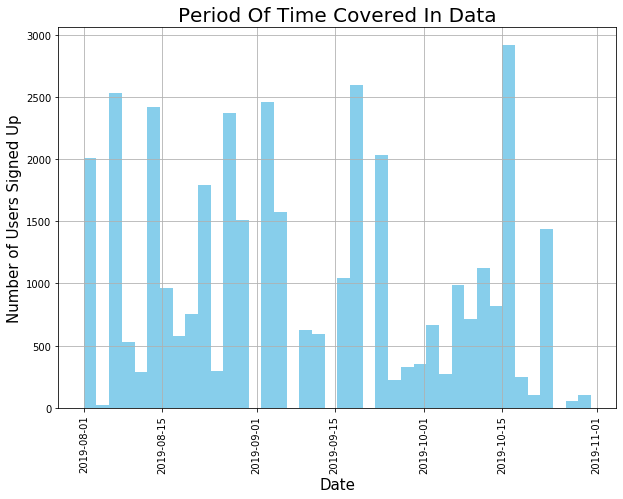

In [61]:
hist = telecom_data['date_start'].hist(bins=40,xrot=90,figsize=(10, 7),color='SkyBlue')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Number of Users Signed Up',fontsize=15)
plt.title('Period Of Time Covered In Data',fontsize=20)
plt.show()

There is no consistency in the data. Users who signed up at the beginning are dropped from the data updates. I will create a cohort to demonstrate the pattern that there are different users in each period. I mentioned creating a retention matrix in the decomposition so that I will follow through to some extent.

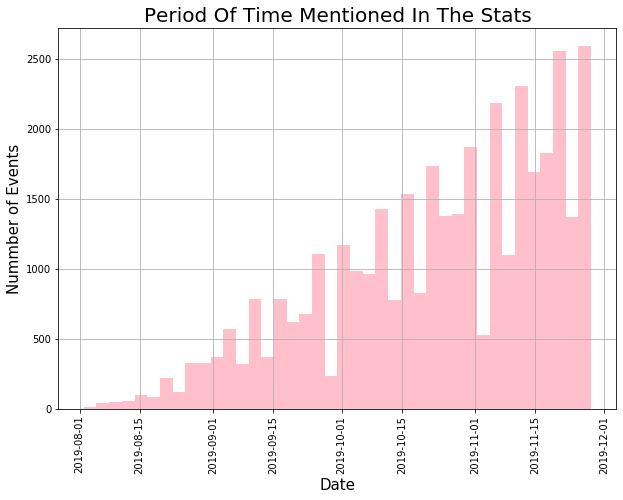

In [62]:
hist = telecom_data['date_stats'].hist(bins=40,xrot=90,figsize=(10, 7),color='Pink')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Nummber of Events',fontsize=15)
plt.title('Period Of Time Mentioned In The Stats',fontsize=20)
plt.show()

The date_stats data looks more cohesive, but again, it is not uploaded simultaneously, so we cannot rely on it for detemining which times are more popular tha others.

### Analysing Users <a name="analysingusers"></a>

How many users per day (on average) do operators sevice? 

In [63]:
telecom_data.groupby(['user_id'])['operator_id'].count().reset_index().sort_values(by='operator_id',ascending=False)['operator_id'].mean()

129.65277777777777

In [64]:
#Determine the most popular tariff plan if the data allows.
tariff_popularity = telecom_data.groupby(['tariff_plan'])['user_id'].nunique().reset_index().sort_values(by='user_id',ascending=False)
tariff_popularity

,tariff_plan,user_id
2,C,156
1,B,101
0,A,31


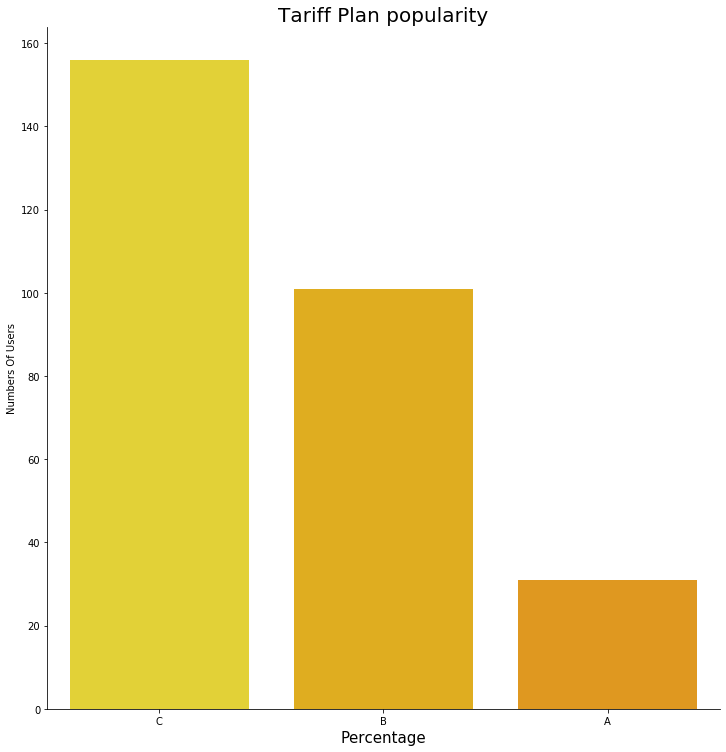

In [65]:
sns.catplot(x="tariff_plan", y="user_id",kind="bar",data=tariff_popularity ,height=10,palette="Wistia")
plt.title('Tariff Plan popularity',fontsize=20)

plt.xlabel("Percentage",fontsize=15)
plt.ylabel("Numbers Of Users")
plt.xticks([0,1,2], ["C", "B", "A"])
plt.show()

The most popular tariff is C after which goes B and then A. 

In [66]:
telecom_clusters = telecom_data.copy()
telecom_clusters.head(1)

,user_id,tariff_plan,date_start,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_stats
1,166713,A,2019-08-15,in,False,891918.0,False,1.0,40.0,62.0,2019-08-22


In [67]:
telecom_clusters["is_missed_call"] = telecom_clusters["is_missed_call"].astype(int)
telecom_clusters['internal'] = telecom_clusters['is_missed_call'].astype(int)
telecom_clusters.head(1)

,user_id,tariff_plan,date_start,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_stats
1,166713,A,2019-08-15,in,0,891918.0,0,1.0,40.0,62.0,2019-08-22


In [68]:
telecom_clusters.drop(['tariff_plan','direction','date_start','date_stats'],axis=1,inplace=True)

### Silhouette Analysis <a name="silhouette"></a>

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.5745566973301872
For n_clusters = 6 The average silhouette_score is : 0.43902711183132426


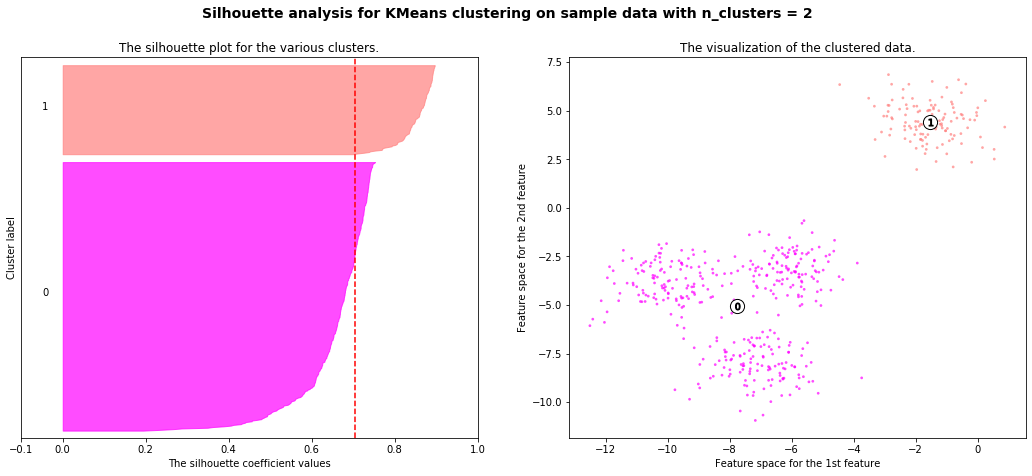

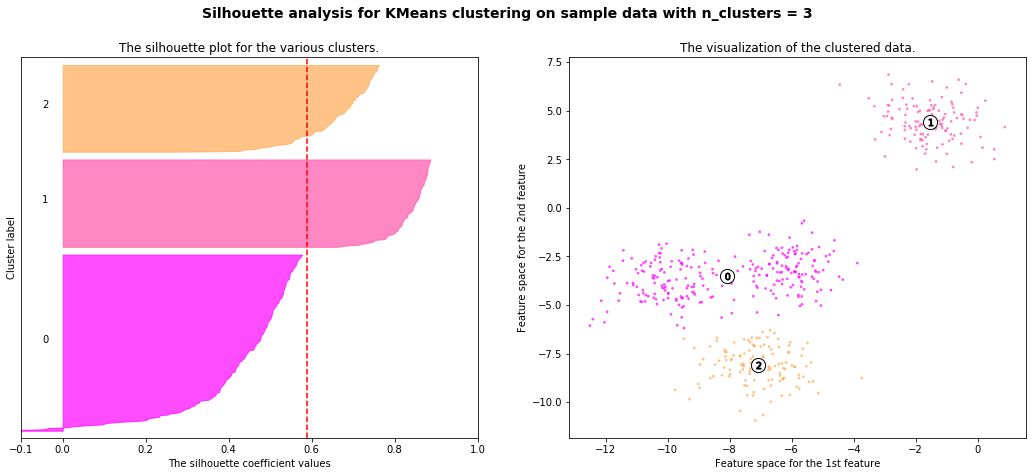

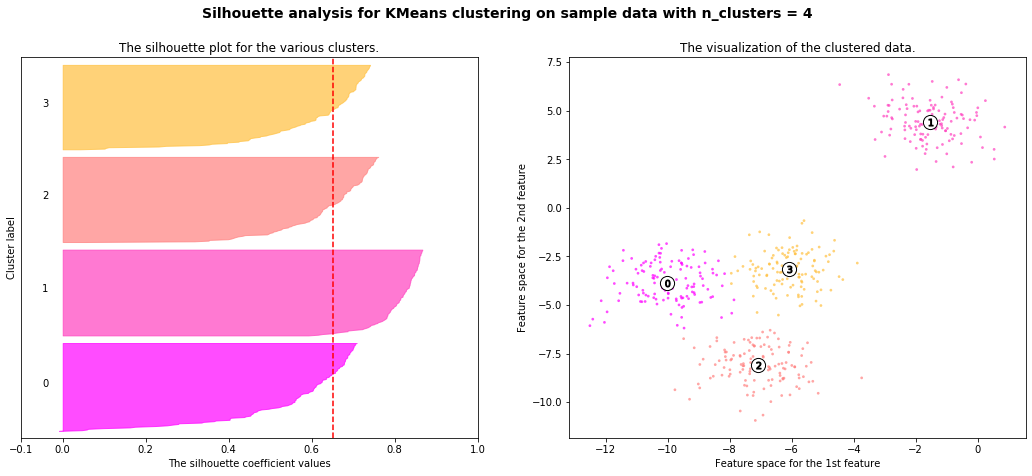

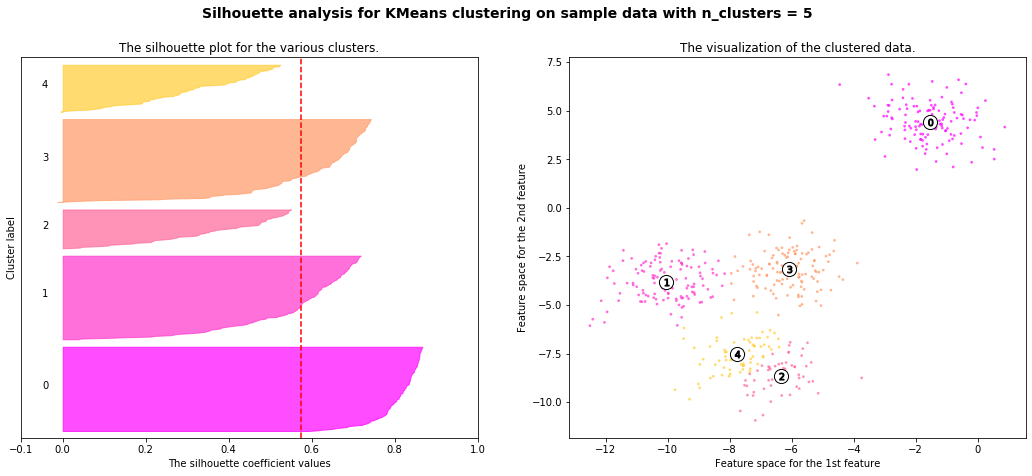

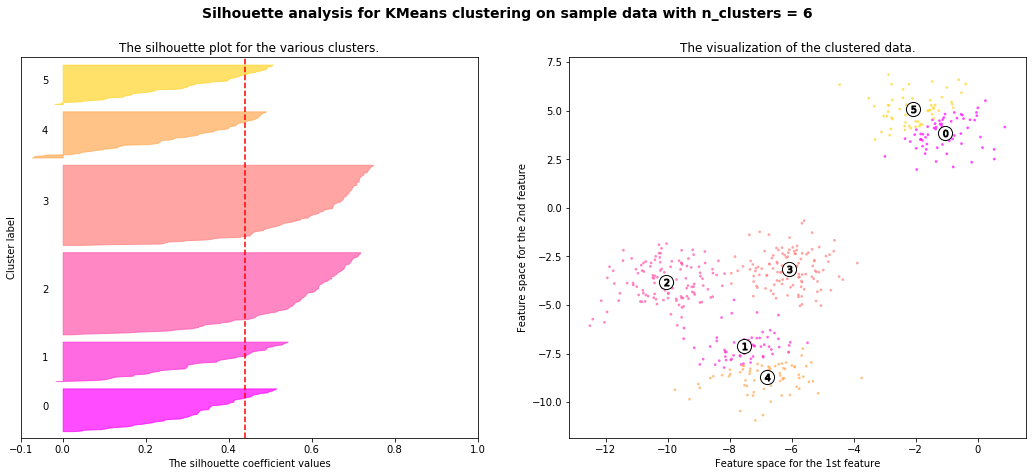

In [69]:
print(__doc__)

X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1) 

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)


    ax1.set_xlim([-0.1, 1])

    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])


    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)


    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spring(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)


        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))


        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")


    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    colors = cm.spring(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')


    centers = clusterer.cluster_centers_

    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Based on the graphs, we see that n_clusters is equal to two would not be a good option, as it formed one big cluster by grouping other subclusters. 

With n_clusters equal 3, a considerable part of the cluster is below the line, hence, below the average silhouette score. 

With 6, it is the same problem. With 5, one of the clusters is below the line, although it is more balanced than n_clusters=6. Based on the graphs, I would say that the ideal number of clusters the ideal number of clusters is four.

### Plot Distributions Of Features For The Clusters  <a name="clusters"></a>

In [70]:
data_for_hists = telecom_clusters.copy()

X = telecom_clusters.drop('operator_id', axis = 1)
sc = StandardScaler()
X_sc = sc.fit_transform(X)
km = KMeans(n_clusters = 4, random_state=0)
labels = km.fit_predict(X_sc)
data_for_hists['cluster_km'] = labels
 
idx = 0


In [71]:
data_for_hists.head();

In [72]:
import os

if not os.path.exists('images'):os.mkdir('images')

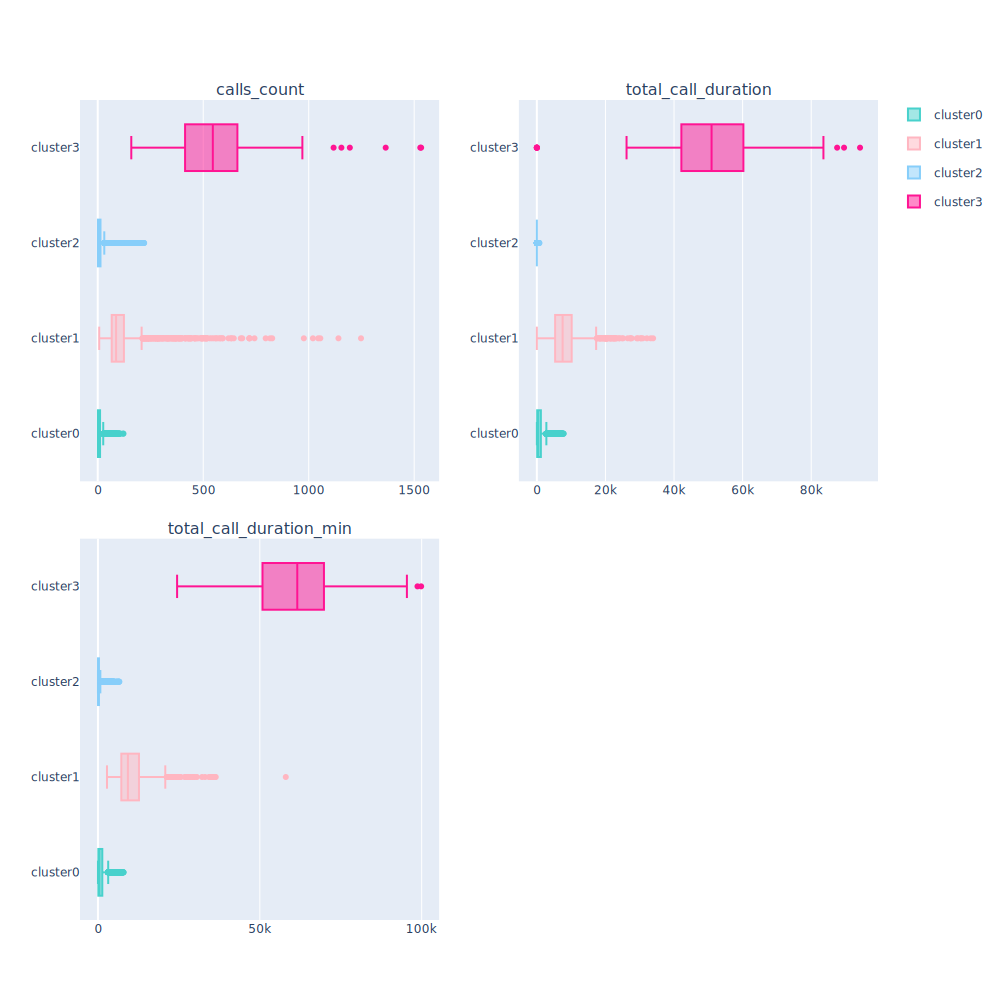

In [73]:
idx = 0
r = (math.floor(idx/2) + 1)
c = (idx%2 + 1)
legend = True


fig1 = make_subplots(rows=2, cols=2,
                   subplot_titles=('calls_count', 'total_call_duration', 'total_call_duration_min'),
                    vertical_spacing=0.07)

# is_missed_call
fig1.add_trace(go.Box(x=data_for_hists.query('cluster_km == 0')['calls_count'],
                           name='cluster0', legendgroup='cluster0',
                           marker_color = 'MediumTurquoise'),
             row=1, col=1)
fig1.add_trace(go.Box(x=data_for_hists.query('cluster_km == 1')['calls_count'],
                           name='cluster1', legendgroup='cluster1',
                           marker_color = 'lightpink'),
             row=1, col=1)
fig1.add_trace(go.Box(x=data_for_hists.query('cluster_km == 2')['calls_count'],
                           name='cluster2', legendgroup='cluster2',
                           marker_color = 'lightskyblue'),
             row=1, col=1)
fig1.add_trace(go.Box(x=data_for_hists.query('cluster_km == 3')['calls_count'],
                           name='cluster3', legendgroup='cluster3',
                           marker_color = 'deeppink'),
             row=1, col=1)



# total_call_duration
fig1.add_trace(go.Box(x=data_for_hists.query('cluster_km == 0')['call_duration'],
                           name='cluster0', legendgroup='cluster0',
                           marker_color = 'MediumTurquoise',
                          showlegend=False),
             row=1, col=2)
fig1.add_trace(go.Box(x=data_for_hists.query('cluster_km == 1')['call_duration'],
                           name='cluster1', legendgroup='cluster1',
                           marker_color = 'lightpink',
                          showlegend=False),
             row=1, col=2)
fig1.add_trace(go.Box(x=data_for_hists.query('cluster_km == 2')['call_duration'],
                           name='cluster2', legendgroup='cluster2',
                           marker_color = 'lightskyblue',
                          showlegend=False),
             row=1, col=2)
fig1.add_trace(go.Box(x=data_for_hists.query('cluster_km == 3')['call_duration'],
                           name='cluster3', legendgroup='cluster3',
                           marker_color = 'deeppink',
                          showlegend=False),
             row=1, col=2)


# total_call_duration_min
fig1.add_trace(go.Box(x=data_for_hists.query('cluster_km == 0')['total_call_duration'],
                           name='cluster0', legendgroup='cluster0',
                           marker_color = 'MediumTurquoise',
                          showlegend=False),
             row=2, col=1)
fig1.add_trace(go.Box(x=data_for_hists.query('cluster_km == 1')['total_call_duration'],
                           name='cluster1', legendgroup='cluster1',
                           marker_color = 'lightpink',
                          showlegend=False),
             row=2, col=1)
fig1.add_trace(go.Box(x=data_for_hists.query('cluster_km == 2')['total_call_duration'],
                           name='cluster2', legendgroup='cluster2',
                           marker_color = 'lightskyblue',
                          showlegend=False),
             row=2, col=1)
fig1.add_trace(go.Box(x=data_for_hists.query('cluster_km == 3')['total_call_duration'],
                           name='cluster3', legendgroup='cluster3',
                           marker_color = 'deeppink',
                          showlegend=False),
             row=2, col=1)

            
r = (math.floor(idx/2)+1)
c = (idx%2 + 1)
idx = idx+2

#fig1.update_layout(barmode ='overlay',height=1000, width=1000)
fig1.update_traces(opacity= 1)

fig1.show(renderer="svg",height=1000,width=1000)


In [74]:
fig1.write_image("images/fig1.pdf")

### Cluster Descriptions  <a name="clusterdescription"></a>

Given that we have multiple parameters to look on in order to determine which operators are more effecient and which are less.

In [75]:
cluster_0 = data_for_hists.query('cluster_km == 0').describe()
cluster_0

,user_id,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,cluster_km
count,23362.000000,23362.0,23362.000000,23362.0,23362.000000,23362.000000,23362.000000,23362.0
mean,167270.087578,0.0,915852.789573,0.0,8.907414,864.810761,991.671860,0.0
std,579.539169,0.0,20698.637268,0.0,12.276746,1148.060774,1280.701791,0.0
min,166377.000000,0.0,879896.000000,0.0,1.000000,0.000000,0.000000,0.0
25%,166800.000000,0.0,900826.000000,0.0,1.000000,99.000000,126.000000,0.0
50%,167150.000000,0.0,911140.000000,0.0,4.000000,382.000000,448.000000,0.0
75%,167747.000000,0.0,934430.000000,0.0,11.000000,1168.000000,1341.000000,0.0
max,168606.000000,0.0,973286.000000,0.0,122.000000,7811.000000,7914.000000,0.0


In [76]:
cluster_zero_difference = cluster_0['total_call_duration'].mean() // cluster_0['calls_count'].mean()
cluster_zero_difference

1.0

Cluster Zero has operators with a small number of calls, missed calls, but small call duration. Given that this cluster, in particular, has more missed calls comparing to other groups, I would say that shorter call duration is not a good thing but rather, lack of interest in assistance of the customers. So this cluster is Innifecient

In [77]:
cluster_1 = data_for_hists.query('cluster_km == 1').describe()
cluster_1

,user_id,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,cluster_km
count,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.0
mean,167685.374529,0.102487,925350.305953,0.102487,129.507159,8071.629239,10640.119819,1.0
std,638.635379,0.303402,21326.166188,0.303402,133.277933,5051.734974,5141.084704,0.0
min,166405.000000,0.000000,879896.000000,0.000000,7.000000,0.000000,2791.000000,1.0
25%,167285.000000,0.000000,919162.000000,0.000000,66.500000,5334.500000,7217.500000,1.0
50%,167650.000000,0.000000,926486.000000,0.000000,87.000000,7514.000000,9253.000000,1.0
75%,168361.000000,0.000000,945288.000000,0.000000,124.000000,10150.000000,12669.000000,1.0
max,168466.000000,1.000000,965544.000000,1.000000,1248.000000,33897.000000,58027.000000,1.0


In [78]:
cluster_one_difference = cluster_1['total_call_duration'].mean() // cluster_1['calls_count'].mean()
cluster_one_difference

34.0

Cluster 1 does not have missed calls, but the call count is not significant. So, while it is better than Cluster Zero, it is still not efficient. 

In [79]:
cluster_2 = data_for_hists.query('cluster_km == 2').describe()
cluster_2

,user_id,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,cluster_km
count,12559.000000,12559.0,12559.000000,12559.0,12559.000000,12559.000000,12559.00000,12559.0
mean,167321.286488,1.0,917002.378374,1.0,13.654192,1.751573,310.15686,2.0
std,617.230690,0.0,21811.172148,0.0,24.187588,22.667172,586.67349,0.0
min,166377.000000,1.0,879896.000000,1.0,1.000000,0.000000,0.00000,2.0
25%,166782.000000,1.0,900594.000000,1.0,1.000000,0.000000,19.00000,2.0
50%,167175.000000,1.0,915360.000000,1.0,4.000000,0.000000,80.00000,2.0
75%,167888.000000,1.0,937808.000000,1.0,13.000000,0.000000,308.00000,2.0
max,168606.000000,1.0,973120.000000,1.0,220.000000,741.000000,6613.00000,2.0


In [80]:
cluster_two_difference = cluster_2['total_call_duration'].mean() // cluster_2['calls_count'].mean()
cluster_two_difference

1.0

Cluster two is the biggest in bulk. It looks oversaturated with numbers, which is good at first glance, but it also has operators who miss more than one call on average, and in terms of the ratio of calls and duration, it has the worst. So this group has a good number of calls but is not up to the standards.

In [81]:
cluster_3 = data_for_hists.query('cluster_km == 3').describe()
cluster_3

,user_id,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,cluster_km
count,92.000000,92.000000,92.000000,92.000000,92.00000,92.000000,92.000000,92.0
mean,166657.304348,0.054348,894156.434783,0.054348,576.51087,49938.000000,60561.989130,3.0
std,291.314291,0.227945,16422.053087,0.227945,262.78042,18053.873012,16177.991838,0.0
min,166582.000000,0.000000,885876.000000,0.000000,159.00000,0.000000,24450.000000,3.0
25%,166582.000000,0.000000,885876.000000,0.000000,415.50000,42196.500000,50835.750000,3.0
50%,166582.000000,0.000000,885890.000000,0.000000,545.50000,50944.000000,61574.500000,3.0
75%,166582.000000,0.000000,885890.000000,0.000000,662.00000,60071.500000,69707.000000,3.0
max,167827.000000,1.000000,929428.000000,1.000000,1533.00000,94237.000000,99839.000000,3.0


In [82]:
cluster_three_difference = cluster_3['total_call_duration'].mean() // cluster_3['calls_count'].mean()
cluster_three_difference

90.0

Cluster 3 has the best balance of the call duration length, the number of missed calls, and the calls. So It is the most efficient group. 

In [83]:
#addig a column for efficiency

conditions = [
    (data_for_hists['cluster_km'] == 1),
    (data_for_hists['cluster_km'] == 3),
    (data_for_hists['cluster_km'] == 0)]
choices = ['Efficient','High Volume Of Calls But Long Waiting', 'Not Many Calls/Long Waiting']
data_for_hists['efficiency'] = np.select(conditions, choices, default='Unefficient')
data_for_hists.head() ;

In [84]:
efficiency_distribution = data_for_hists.groupby(['efficiency'])['operator_id'].count().reset_index().sort_values(by='operator_id',ascending=False)
efficiency_distribution = efficiency_distribution.loc[[0,1,2,3,], :]
efficiency_distribution


,efficiency,operator_id
0,Efficient,1327
1,High Volume Of Calls But Long Waiting,92
2,Not Many Calls/Long Waiting,23362
3,Unefficient,12559


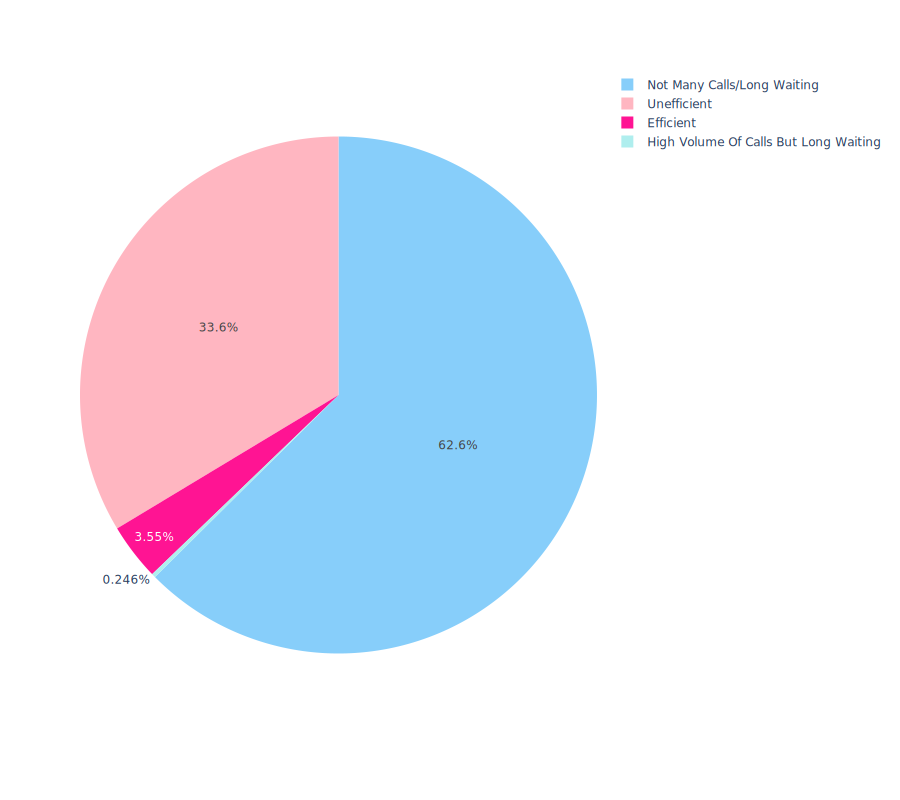

In [85]:
fig2 = px.pie(efficiency_distribution, values='operator_id', names='efficiency', color='efficiency',
             color_discrete_map={'Efficient':'deeppink',
                                 'High Volume Of Calls But Long Waiting':'paleturquoise',
                                 'Not Many Calls/Long Waiting':'lightskyblue',
                                 'Unefficient':'lightpink'})

fig2.show(renderer="svg",height=800,width=900)


In [86]:
fig2.write_image("images/fig2.pdf")

In this graph, we see a distribution of operators across the categories of efficiency. It is challenging to strike a balance. The question here is what causes long waiting. At the same time, the category with a high volume of calls and long waiting is reasonable. Long calls or a massive number of calls yield into long waiting, but what about the case where the number of calls is relatively small, but the call duration is long even without the waiting period. It appears that inefficiency is not the operator's problem alone, and there is some encouragement for more extended conversations for users.

In [87]:
plot_data = data_for_hists.copy()

In [88]:
telecom_merge=pd.merge(left=plot_data,right=telecom_clients,how='outer',on=['user_id'])

#telecom_merge.head() #test

In [89]:
telecom_merge.dropna(how='any', inplace=True)

In [90]:
distribution = []
for i in telecom_merge.tariff_plan.unique():
    group=telecom_merge[telecom_merge.tariff_plan==i].groupby(['efficiency','tariff_plan'])['operator_id'].count().reset_index()\
    .sort_values(by='operator_id',ascending=False)
    display(group)
    distribution.append(group);
    

,efficiency,tariff_plan,operator_id
2,Not Many Calls/Long Waiting,A,6215
3,Unefficient,A,3781
0,Efficient,A,905
1,High Volume Of Calls But Long Waiting,A,87


,efficiency,tariff_plan,operator_id
2,Not Many Calls/Long Waiting,C,8799
3,Unefficient,C,4279
0,Efficient,C,231
1,High Volume Of Calls But Long Waiting,C,5


,efficiency,tariff_plan,operator_id
1,Not Many Calls/Long Waiting,B,8348
2,Unefficient,B,4499
0,Efficient,B,191


In [91]:
distribution = pd.concat(distribution)
distribution.head(20)

,efficiency,tariff_plan,operator_id
2,Not Many Calls/Long Waiting,A,6215
3,Unefficient,A,3781
0,Efficient,A,905
1,High Volume Of Calls But Long Waiting,A,87
2,Not Many Calls/Long Waiting,C,8799
3,Unefficient,C,4279
0,Efficient,C,231
1,High Volume Of Calls But Long Waiting,C,5
1,Not Many Calls/Long Waiting,B,8348
2,Unefficient,B,4499


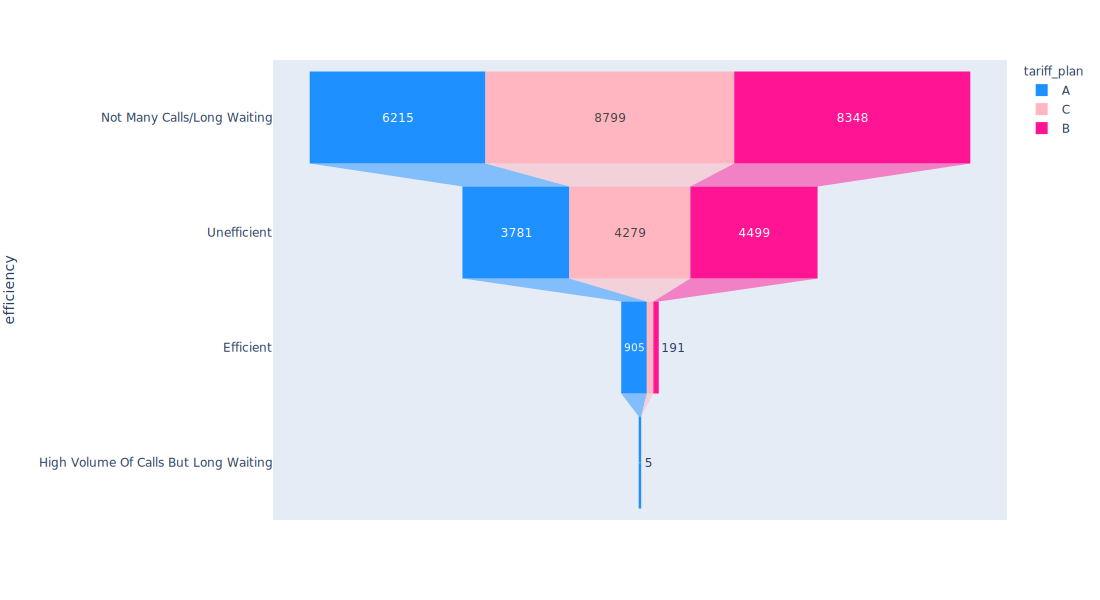

In [92]:
fig3 = px.funnel(distribution,x='operator_id',y='efficiency',color='tariff_plan',opacity = 1,color_discrete_sequence =['DodgerBlue','lightpink','Deeppink'])

fig3.show(renderer="svg",height=600,width=1100)

In [93]:
fig3.write_image("images/fig3.pdf")

    
![](attachment:111.jpeg)



Based on the graph, we see that the distributions between the tariff plans are even proportionally, not the same. Interestingly, more popular plans such as B and C have less efficient operators than tariff A. Now, maybe the company should reconsider the threshold for efficiency as it does not reflect the demand. We do not know the attrition rate among users, so we can't judge that.

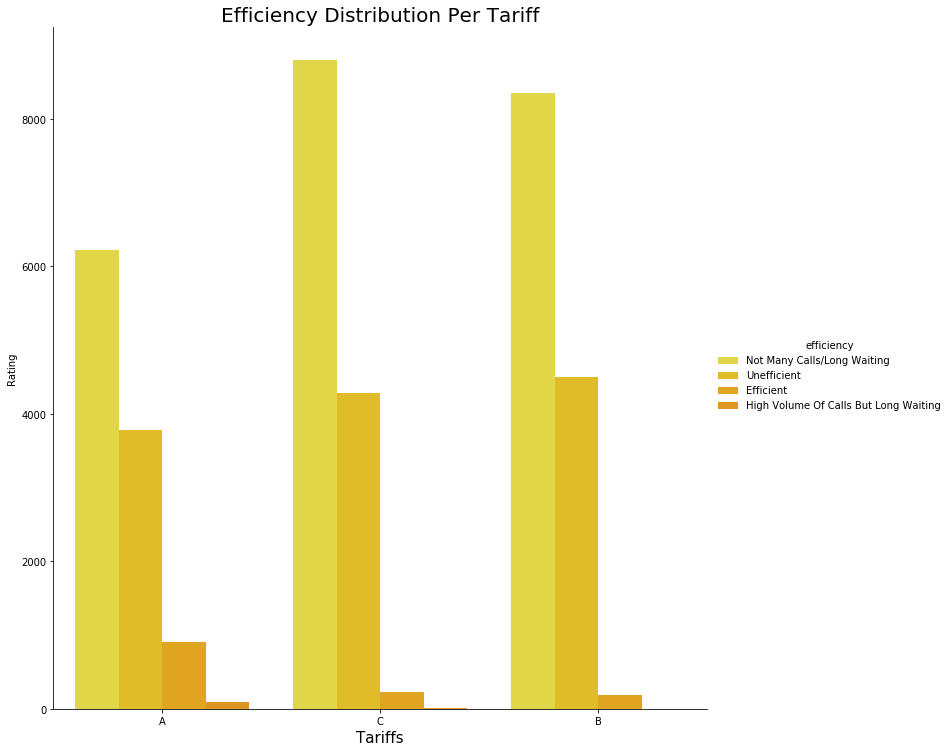

In [94]:
sns.catplot(x="tariff_plan", y="operator_id", hue="efficiency", kind="bar", data=distribution, height=10,palette='Wistia')
plt.title('Efficiency Distribution Per Tariff',fontsize=20)

plt.xlabel("Tariffs",fontsize=15)
plt.ylabel("Rating")

plt.show()

This graph displays the efficiency distribution per tariff. Here we see the same interesting dynamics. Proportionally speaking, Tariff A is of better quality as it has more efficient users and fewer operators with a long waiting period and not many calls. Yet, somehow it is still not the most popular tariff.

### Conclusion  <a name="conclusion3"></a>

After looking at clusters and tariffs, it seems like there is some factor in the mix that we do not know about, making it difficult for operators to be considered efficient while keeping users happy. It seems that it would be a better strategy to adjust tariffs so that the quality would be present from both sides - the service and the customers.

## Step 3. Creating a hypothesis <a name="hypothesis"></a>

#### The tariff plan of the clients affects the effectiveness of operators.

We examined the groups and determined that the samples are different from one another, but it would be essential to see to what extend. For example, it is possible that they are not significantly different. The argument that the tariff plan affects the operators' ability to work correctly or the company's expectations, and a particular tariff does not match. With this in mind:

The null hypothesis: The groups are not significantly different

The Alternative Hypothesis: they are




#### The hypothesis stays the same throughout the entire testing, with the only difference in groups we will examine.

In [95]:
pivot = telecom_merge.pivot_table(index='efficiency',values='operator_id',columns='tariff_plan',aggfunc=lambda x: x.nunique()).reset_index()
pivot.head()

tariff_plan,efficiency,A,B,C
0,Efficient,88.0,38.0,43.0
1,High Volume Of Calls But Long Waiting,4.0,NaN,2.0
2,Not Many Calls/Long Waiting,294.0,367.0,373.0
3,Unefficient,277.0,319.0,264.0


In [96]:
def check_hypothesis(group1,group2, rate, alpha=0.05):
    #let's start with successes, using indexing on our pivot table
    successes1=pivot[pivot.efficiency==rate][group1].iloc[0]
    successes2=pivot[pivot.efficiency==rate][group2].iloc[0]
    print( "Success for group", group1, "is",successes1, "for event", rate,"\n",
          "Success for group", group2, "is",successes2, "for event", rate,"\n")

In [97]:
check_hypothesis('A','B', 'Efficient', alpha=0.05)

Success for group A is 88.0 for event Efficient 
 Success for group B is 38.0 for event Efficient 



For the group A the value is 88 and for the group B it is 38.

In [98]:
def check_hypothesis(group1,group2, rate, alpha=0.05):

    successes1=pivot[pivot.efficiency==rate][group1].iloc[0]
    successes2=pivot[pivot.efficiency==rate][group2].iloc[0]

    trials1=telecom_merge[telecom_merge.tariff_plan==group1]['operator_id'].nunique()
    trials2=telecom_merge[telecom_merge.tariff_plan==group2]['operator_id'].nunique()
    
    print( "Success for group", group1, "is",successes1, "for event", rate,"\n",
          "Success for group", group2, "is",successes2, "for event", rate,"\n",
         "Trials for group", group1, "is",trials1,"\n",
         "Trials for group", group2, "is",trials2,"\n")

In [99]:
check_hypothesis('A','B', 'Efficient', alpha=0.05)

Success for group A is 88.0 for event Efficient 
 Success for group B is 38.0 for event Efficient 
 Trials for group A is 309 
 Trials for group B is 390 



The values for the trials, meaning the original number of users in the samples are:
- 309 (for group A)
- 390 (for group B)



#### Testing the hypothesis for the groups A and B:
As stated above, the hypothesis is the same.

In [100]:
def check_hypothesis(group1,group2, rate, alpha=0.05):

    successes1=pivot[pivot.efficiency==rate][group1].iloc[0]
    successes2=pivot[pivot.efficiency==rate][group2].iloc[0]

    trials1=telecom_merge[telecom_merge.tariff_plan==group1]['operator_id'].nunique()
    trials2=telecom_merge[telecom_merge.tariff_plan==group2]['operator_id'].nunique()
    
    #proportion for success in the first group
    p1 = successes1/trials1

    #proportion for success in the second group
    p2 = successes2/trials2

    #proportion in a combined dataset
    p_combined = (successes1 + successes2) / (trials1 + trials2)

  
    difference = p1 - p2
    
    
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

  
    distr = stats.norm(0, 1) 


    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Reject H0 for",rate, 'and groups',group1,group2)
    else:
        print("Fail to Reject H0 for", rate,'and groups',group1,group2) 

In [101]:
check_hypothesis('A','B', 'Efficient', alpha=0.05)

p-value:  1.5582801715652295e-10
Reject H0 for Efficient and groups A B


The hypothesis is rejected, meaning that there is a significant difference in the groups' proportion at this stage. Now we will see for the rest of the analysis for the sample:


In [102]:
for i in pivot.efficiency.unique():
    check_hypothesis('A','B', i, alpha=0.05)

p-value:  1.5582801715652295e-10
Reject H0 for Efficient and groups A B
p-value:  nan
Fail to Reject H0 for High Volume Of Calls But Long Waiting and groups A B
p-value:  0.5458132616978544
Fail to Reject H0 for Not Many Calls/Long Waiting and groups A B
p-value:  0.0036424609369276606
Reject H0 for Unefficient and groups A B


The hypothesis is only rejected for efficient and inefficient operators indicating that the difference between groups is significant at those stages, but it is not for others. It brings us closer to confirming that the tariff plans do affect the quality of operators (or what is considered a high standard by the company)

#### Checking The Results Using SIdak Correction

The Sidak correction is derived by assuming that the individual tests are independent and it is not as strict as Bonferrioni correction where it is almost impossible to reject the null hypothesis.For the comparison between one group over another as opposed to joined control group we should not use Mann-Whitney because the different is not significant enough and generally speaking, our sample is not big enough.

In [103]:
FWER = 1-(1-0.05)**(1/12)
alpha_sidak = 1-(1-FWER)**(1/12)

def check_hypothesis(group1,group2, rate, alpha_sidak):

    successes1=pivot[pivot.efficiency==rate][group1].iloc[0]
    successes2=pivot[pivot.efficiency==rate][group2].iloc[0]

    trials1=telecom_merge[telecom_merge.tariff_plan==group1]['operator_id'].nunique()
    trials2=telecom_merge[telecom_merge.tariff_plan==group2]['operator_id'].nunique()
    
    #proportion for success in the first group
    p1 = successes1/trials1

    #proportion for success in the second group
    p2 = successes2/trials2

    #proportion in a combined dataset
    p_combined = (successes1 + successes2) / (trials1 + trials2)

  
    difference = p1 - p2
    
    
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

  
    distr = stats.norm(0, 1) 


    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value) 
    
    if (p_value < alpha_sidak):
        print("Reject H0 for",rate, 'and groups',group1,group2)
    else:
        print("Fail to Reject H0 for", rate,'and groups',group1,group2)

In [104]:
check_hypothesis('A','B', 'Efficient', alpha_sidak)

p-value:  1.5582801715652295e-10
Reject H0 for Efficient and groups A B


Sidak still rejects the hypothesis indicating that there is a significant difference.

#### Checking the hypothesis  groups 247 ad 248

The same hypothesis as stated at the beginning of the sections, but different sample combination.

In [105]:
def check_hypothesis(group2,group3, rate, alpha=0.05):
    successes2=pivot[pivot.efficiency==rate][group2].iloc[0]
    successes3=pivot[pivot.efficiency==rate][group3].iloc[0]
    
    #for trials we can go back to original df or used a pre-aggregated data
    trials2=telecom_merge[telecom_merge.tariff_plan==group2]['operator_id'].nunique()
    trials3=telecom_merge[telecom_merge.tariff_plan==group3]['operator_id'].nunique()
    
    #proportion for success in the first group
    p1 = successes2/trials2

   #proportion for success in the second group
    p2 = successes3/trials3

    # proportion in a combined dataset
    p_combined = (successes2 + successes3) / (trials2 + trials3)

  
    difference = p1 - p2
    
    
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials2 + 1/trials3))

  
    distr = stats.norm(0, 1) 


    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Reject H0 for",rate, 'and groups',group2,group3)
    else:
        print("Fail to Reject H0 for", rate,'and groups',group2,group3)  

In [106]:
check_hypothesis('B','C', 'Efficient', alpha=0.05)

p-value:  0.500733139479701
Fail to Reject H0 for Efficient and groups B C


Here yet again we see that the values are not different from one another. Let's see if they are different throughout the entire funnel.

In [107]:
for i in pivot.efficiency.unique():
    check_hypothesis('B','C', i, alpha=0.05)

p-value:  0.500733139479701
Fail to Reject H0 for Efficient and groups B C
p-value:  nan
Fail to Reject H0 for High Volume Of Calls But Long Waiting and groups B C
p-value:  0.023830999606023084
Reject H0 for Not Many Calls/Long Waiting and groups B C
p-value:  3.271770119717132e-05
Reject H0 for Unefficient and groups B C


In this case, the hypothesis is not rejected for Effecient and Calls But Long Waiting for groups B and C which means that at that stage the groups are the same. We reject the hypothesis for Not waiting and Unneficient for groups B and C, which means that they are different. So basically, there is definitely something to be said about fluctuating quality between the tariffs.

#### Checking groups B and C with Sidak correction

In [108]:
FWER = 1-(1-0.05)**(1/12)
alpha_sidak = 1-(1-FWER)**(1/12)

def check_hypothesis(group2,group3, rate, alpha_sidak):
    successes1=pivot[pivot.efficiency==rate][group2].iloc[0]
    successes2=pivot[pivot.efficiency==rate][group3].iloc[0]

    trials1=telecom_merge[telecom_merge.tariff_plan==group2]['operator_id'].nunique()
    trials2=telecom_merge[telecom_merge.tariff_plan==group3]['operator_id'].nunique()
    
    #proportion for success in the first group
    p1 = successes1/trials1

   #proportion for success in the second group
    p2 = successes2/trials2

    # proportion in a combined dataset
    p_combined = (successes1 + successes2) / (trials1 + trials2)

  
    difference = p1 - p2
    
    
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

  
    distr = stats.norm(0, 1) 


    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value) 
    
    if (p_value < alpha_sidak):
        print("Reject H0 for",rate, 'and groups',group2,group3)
    else:
        print("Fail to Reject H0 for", rate,'and groups',group2,group3)

In [109]:
check_hypothesis('B','C', 'Efficient', alpha_sidak)

p-value:  0.500733139479701
Fail to Reject H0 for Efficient and groups B C


In the end, for groups B and C we reject the hypothesis which means that the groups are not significantly different.

### Conclusion <a name="conclusion4"></a>

Given that we already know that there are significant similarities and disparities in the datasets, there is no point for the additional comparison. We have seen that the hypothesis is rejected for categories that particularly matter, such as "Efficient" or "Innefecient." Otherwise, no particular pattern would show why some tariffs are more popular than others, and operator's behavior varies based on which user they talk to (in terms of what kind of contract they have). 

## Step 5. Conclusion <a name="conclusion4"></a>

During the preliminary analysis, I cleaned the data, and I removed the duplicates. I did not fill in the missing values as it would not be possible to average out randomly-generated user IDs. Subsequently, I removed the missing values. The data contained outliers that I  removed as well from some columns as it did not make practical sense to keep them. 

As the timeline of the users' registration and the information log into the system were not synchronic, I determined the timeframe of the data collected but did not examine the retention rate as I originally intended - the data was not consistent enough. 

By grouping users between tariffs, I determined the most popular tariff and then which tariff has the most efficient operators. 


I determined the operator's efficiency through clustering. The data was split into four clusters as it was the best option, as we saw on the silhouette analysis graphs. 

We can conclude that operator's inefficiency (in its definition) may need to be reassessed.
The inefficiency may be caused by tariffs' conditions that, for example, encourage users to spend more time on the phone or requires operators to call clients rather than another way around. Maybe it has something to do with a price. Either way, the solution would require a two-sided approach.

## Tableau Presentation

please see the link below: 

https://public.tableau.com/profile/anna4181#!/vizhome/TelecomCompany_16103971683300/TelecomCompanyPresentation